# DAY4(21/07/11)
## 목적 : 네이버 영화 리뷰 감성 분석 모델링 구현하기
### 1. 간단한 EDA와 전처리를 통해 데이터 품질을 높일 것이다.
### 2. CNN으로도 NLP 모델링이 가능하기 떄문에, 기본적인 CNN과 LSTM 모델 구현해서 성능을 비교해볼 것이다.


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [44]:
pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 450kB 39.3MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


### 1. 네이버 리뷰 데이터 호출하기

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
from wordcloud import WordCloud
warnings.filterwarnings(action = 'ignore')

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from konlpy.tag import Okt

In [3]:
train = pd.read_csv('/content/ratings_train.txt', header = 0, delimiter='\t', quoting = 3)
test = pd.read_csv('/content/ratings_test.txt', header = 0, delimiter='\t', quoting = 3)
sample = pd.read_csv('/content/ratings.txt', header = 0, delimiter='\t', quoting = 3)

In [4]:
train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [5]:
test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [6]:
length = train['document'].astype('str').apply(len)
length

0         19
1         33
2         17
3         29
4         61
          ..
149995    19
149996    13
149997    31
149998    27
149999    24
Name: document, Length: 150000, dtype: int64

### 2. 데이터 EDA를 위한 함수 구현 및 시각화 작업

In [27]:
## 데이터의 문장 길이 시긱화
def length_text(data):
    print('리뷰 길이의 최댓값:{}'.format(np.max(data)))
    print('리뷰 길이의 최솟값:{}'.format(np.min(data)))
    print('리뷰 길이의 평균값:{}'.format(np.mean(data)))
    print('리뷰 길이의 표준편차:{}'.format(np.std(data)))
    print('리뷰 길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.hist(data, bins = 200, alpha = 0.5, color = 'r', label = 'word')
    plt.yscale('log', nonposy = 'clip')
    plt.title('Length of Reviews', fontsize = 30)
    plt.xlabel('Length of Review', fontsize = 20)
    plt.ylabel('Number of Review', fontsize = 20)
    
    return plt.show()

## 데이터의 사분위 값 시각화
def length_text2(data):
    print('리뷰 길이의 최댓값:{}'.format(np.max(data)))
    print('리뷰 길이의 최솟값:{}'.format(np.min(data)))
    print('리뷰 길이의 평균값:{}'.format(np.mean(data)))
    print('리뷰 길이의 표준편차:{}'.format(np.std(data)))
    print('리뷰 길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.boxplot(data, labels = ['counts'], showmeans = True)
    plt.title('Length of Reviews', fontsize = 30)

    return plt.show()

## 단어 빈도 수 시각화
def text_size(data):
    data_review = [review for review in data['document'] if type(review) is str]
    wordcloud = WordCloud('NanumGothic.ttf').generate(' '.join(data_review))
    plt.figure(figsize = (20, 10))
    plt.title('단어의 빈도 수', fontsize = 30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return plt.show()

## 종속 변수(타겟)의 비율
def target_ratio(data):
    print('긍정 리뷰의 갯수:', data['label'].value_counts()[1])
    print('부정 리뷰의 갯수:', data['label'].value_counts()[0])
    plt.figure(figsize = (20, 10))
    plt.rc('font', family='NanumBarunGothic') 
    plt.title('타겟의 비율', fontsize = 30)
    sns.countplot(data['label'])
    
    return plt.show()

리뷰 길이의 최댓값:158
리뷰 길이의 최솟값:1
리뷰 길이의 평균값:35.23749333333333
리뷰 길이의 표준편차:29.582262651515517
리뷰 길이의 중간값:27.0


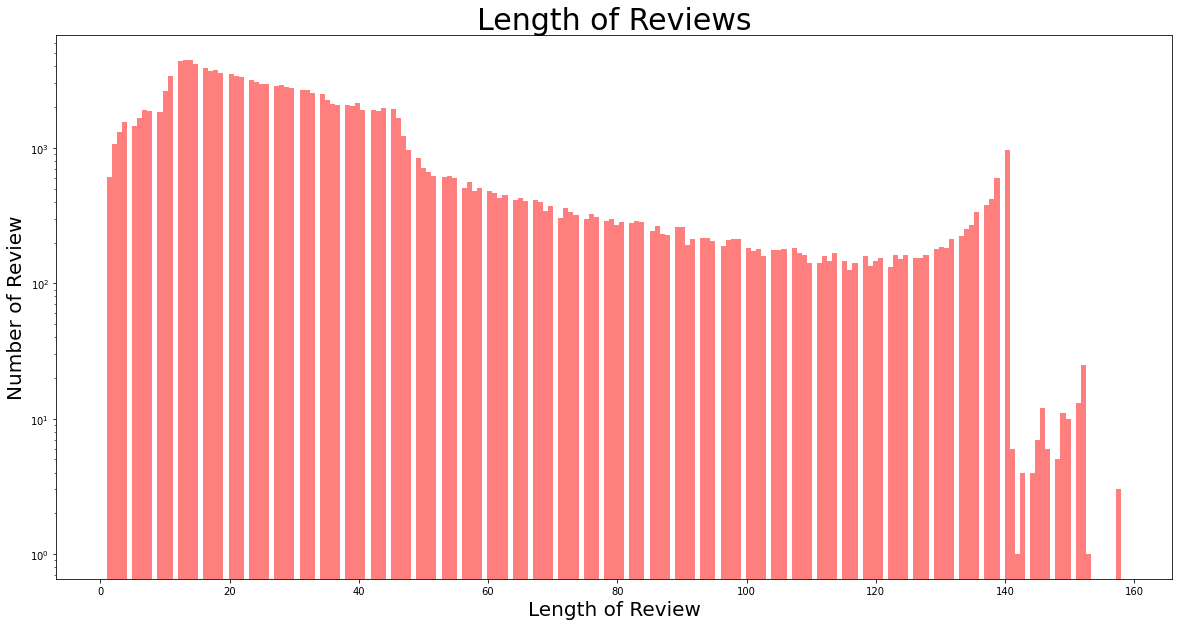

In [8]:
length_text(length)

### 1. 문장 길이를 시각화 한 결과 대략 20자를 기준으로 댓글의 수가 밀집되어 있는 것으로 보인다.
### 2. 그리고 글자수가 늘어남에 따라 빈도수는 줄어들다가, 140자 쯤에 갑자기 증가하게 된다.
### 3. 확인을 해보니, 한글 기준으로 140자가 리뷰에서 쓸 수 있는 최대 글자라는 것이 나타났다.
### 4. 그 이상의 값은 한글 기준이 아니라 영어나 숫자일 가능성이 높다.

리뷰 길이의 최댓값:158
리뷰 길이의 최솟값:1
리뷰 길이의 평균값:35.23749333333333
리뷰 길이의 표준편차:29.582262651515517
리뷰 길이의 중간값:27.0


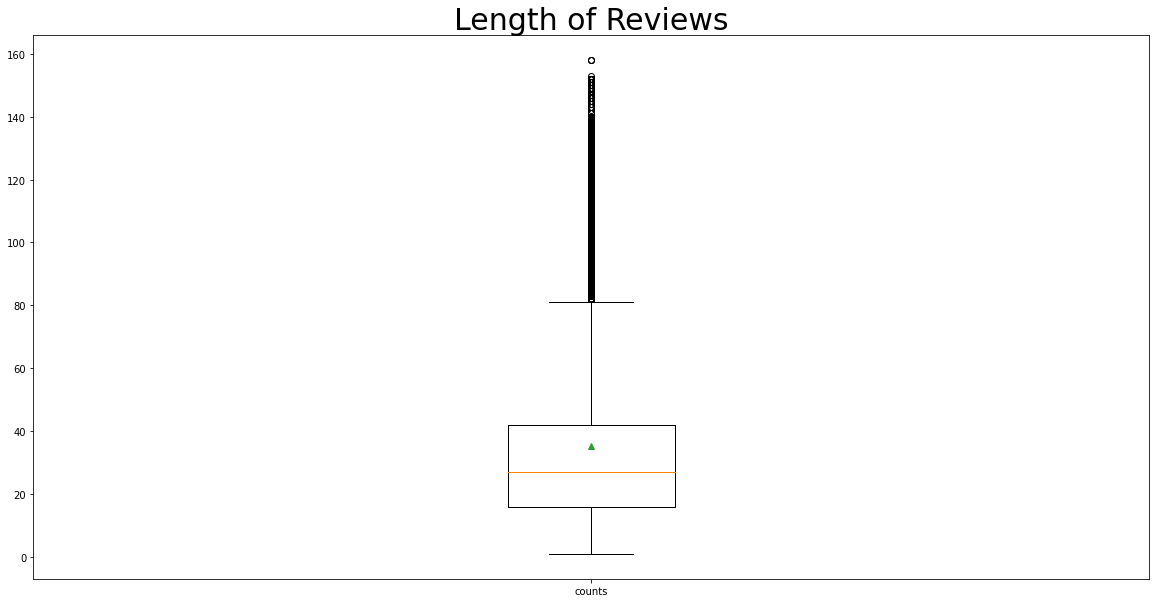

In [9]:
length_text2(length)

### 1. 평균값이 시각화에서 35자로 보인다. 
### 2. 이상치가 있는 것을 확인된다.

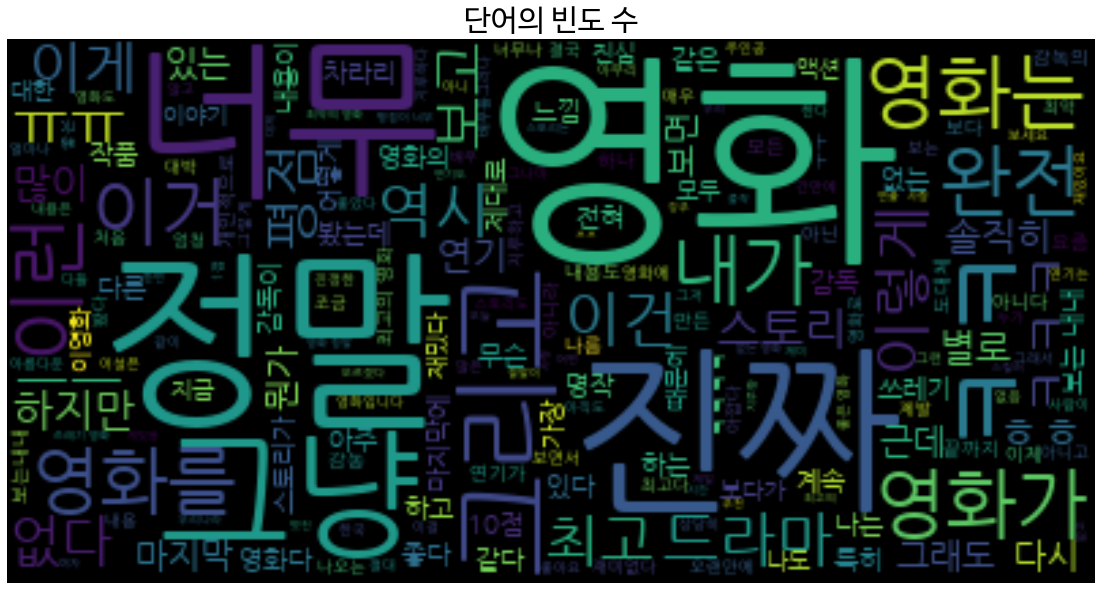

In [22]:
text_size(train)

### 1. 단어의 빈도수를 보니, 영어 텍스트와 달리 html과 연관된 단어들은 없는 것으로 파악된다.
### 2. 너무, 정말, 그냥, 진짜, 영화와 같이 불용어로 보이는 단어의 빈도가 높은 것으로 보인다. 모델링을 진행할 때 제거할 필요성이 있다.

긍정 리뷰의 갯수: 74827
부정 리뷰의 갯수: 75173


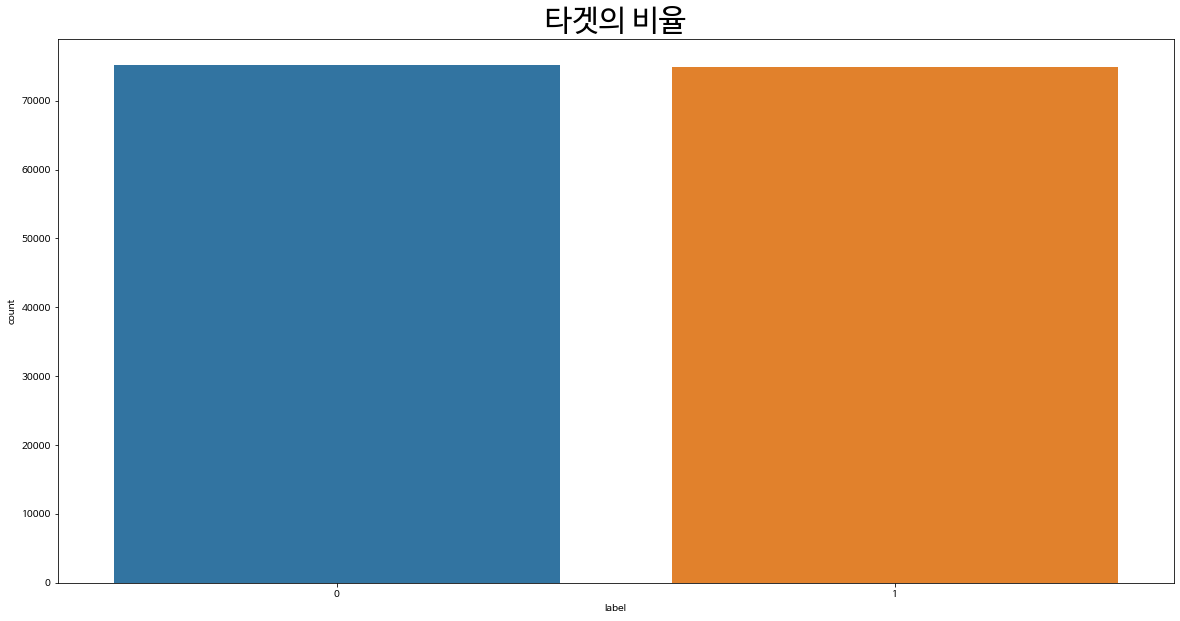

In [28]:
target_ratio(train)

### 1. 긍정과 부정이 라벨 비율은 거의 유사한 것으로 보인다.
### 2. 라벨의 불균형이 크게 없기 때문에, 모델링을 그대로 진행해도 된다.

In [29]:
train_word_counts = train['document'].astype(str).apply(lambda x : len(x.split(' ')))

리뷰 길이의 최댓값:41
리뷰 길이의 최솟값:1
리뷰 길이의 평균값:7.58494
리뷰 길이의 표준편차:6.514041131514094
리뷰 길이의 중간값:6.0


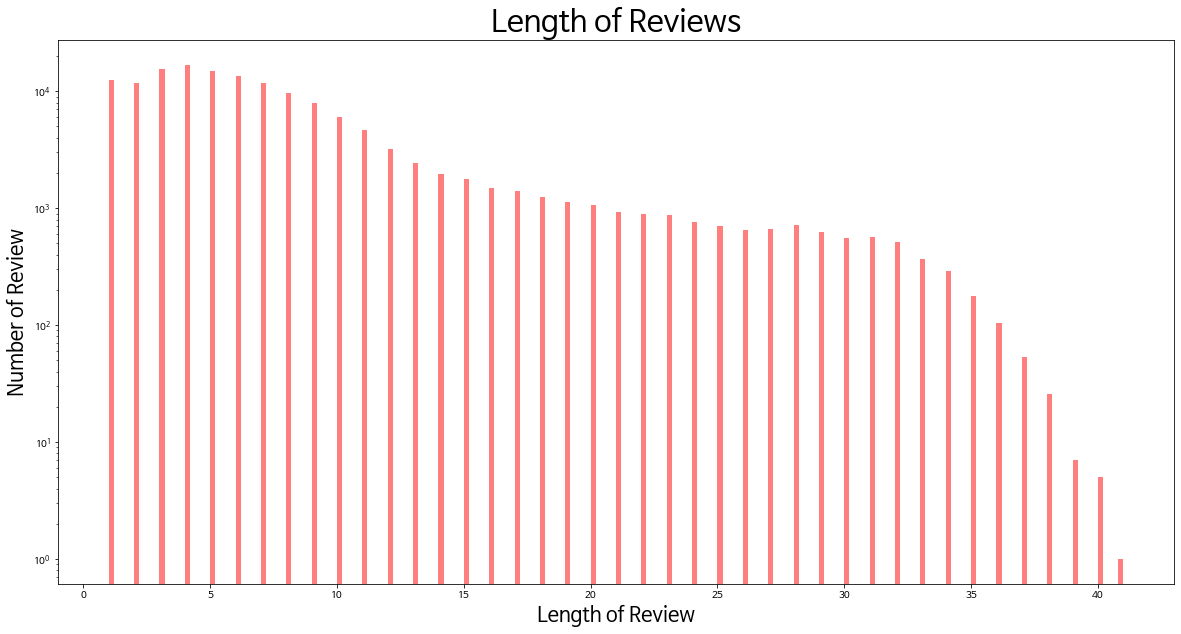

In [31]:
length_text(train_word_counts)

In [34]:
qmarks = np.mean(train['document'].astype(str).apply(lambda x :'?' in x))
fullstop = np.mean(train['document'].astype(str).apply(lambda x : '.' in x))
marks = np.mean(train['document'].astype(str).apply(lambda x : '!' in x))

print('물음표가 있는 질문: {:.2f}%'.format(qmarks*100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop*100))
print('느낌표가 있는 질문: {:.2f}%'.format(marks*100))

물음표가 있는 질문: 8.25%
마침표가 있는 질문: 51.76%
느낌표가 있는 질문: 9.38%


### 3. 데이터 전처리 작업

In [77]:
stop_words = set(['은', '에', '는','냐', 'ㅇ','로써', 'ㅜ', 'ㅠ', '로서', 'ㅋ','ㅎ', '는', '이', '가', '을', '를', '들', '진짜', '정말', '너무', '그리고', '그러나', '그런데', '하지만', '이게', '그래도'])
okt = Okt()

In [78]:
def clean_text(review, okt, remove_stopwords = False, stop_words = []):
    clean_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '',review) ## 한글만 남기기
    clean_text = okt.morphs(clean_text, stem = True) ## 형태소 분리 및 어간 추출

    if remove_stopwords:
        clean_review = [token for token in clean_text if not token in stopwords] # 불용어 제거

    return clean_review

In [79]:
clean_text_list = []
for review in train['document']:
    if type(review) == str:
        clean_text_list.append(clean_text(review, okt, remove_stopwords=True, stop_words = stop_words))
    else :
        clean_text_list.append([])

clean_text_list

[['아', '더빙', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '의',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '하다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '세',
  '부터',
  '초등학교',
  '학년',
  '생인',
  '살다',
  '영화',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '도',
  '아깝다',
  '움'],
 ['원작', '의', '긴장감', '제대로', '살리다', '하다'],
 ['별',
  '반개',
  '도',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '몇',
  '년',
  '인지',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '드라마',
  '가족',
  '도',
  '없다',
  '연기',
  '못',
  '하다',
  '사람',
  '만',
  '모',
  '엿',
  '네'],
 ['액션', '없다', '재미', '있다', '몇', '안되다', '영화'],
 ['왜케',
  '평점',
  '낮다',
  '꽤',
  '볼',
  '만',
  '한',
  '데',
  '헐리우드',
  '식',
  '화려하다',
  '길들이다',
  '있다'],
 ['걍', '인피니트', '짱', '이다

In [80]:
clean_text_test = []
for review in test['document']:
    if type(review) == str:
        clean_text_test.append(clean_text(review, okt, remove_stopwords=True, stop_words = stop_words))
    else :
        clean_text_test.append([])

clean_text

<function __main__.clean_text>

In [82]:
clean_text_test

[['굳다', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '나오다', '제', '심기', '불편하다', '하다'],
 ['음악', '주가', '되다', '최고', '의', '음악', '영화'],
 ['진정하다', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나오다',
  '한',
  '창의력',
  '없다',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '젖다',
  '하다'],
 ['갈수록',
  '개판',
  '되다',
  '중국영화',
  '유치하다',
  '내용',
  '없다',
  '폼',
  '잡다',
  '끝나다',
  '말',
  '도',
  '안되다',
  '무기',
  '에',
  '유치하다',
  '남무',
  '아',
  '그리다',
  '동사서독',
  '같다',
  '영화',
  '이건',
  '류',
  '아',
  '류작',
  '이다'],
 ['이별',
  '의',
  '아픔',
  '뒤',
  '에',
  '찾아오다',
  '새롭다',
  '인연',
  '의',
  '기쁨',
  '모든',
  '사람',
  '그렇다',
  '않다'],
 ['괜찮다', '오랜', '만', '포켓몬스터', '잼밌', '어', '요'],
 ['한국', '독립영화', '의', '한계', '그렇게', '아버지', '되다', '비교', '되다'],
 ['청춘',
  '아름답다',
  '그',
  '아름답다',
  '움',
  '이성',
  '흔들다',
  '놓다',
  '찰나',
  '의',
  '아름답다',
  '움',
  '자다',
  '포착',
  '한',
  '섬세하다',
  '아름답다',
  '수채화',
  '같다',

In [87]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(clean_text_list)
train_sequences = tokenizer.texts_to_sequences(clean_text_list)
test_sequences = tokenizer.texts_to_sequences(clean_text_test)

word_vocab = tokenizer.word_index

MAX_SEQUENCE_LENGTH = 8

X_train = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
y_train = np.array(train['label'])
X_test = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
y_test = np.array(test['label'])

In [88]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((150000, 8), (150000,), (50000, 8), (50000,))

In [106]:
word_vocab

{'영화': 1,
 '보다': 2,
 '하다': 3,
 '의': 4,
 '에': 5,
 '도': 6,
 '없다': 7,
 '이다': 8,
 '있다': 9,
 '좋다': 10,
 '다': 11,
 '한': 12,
 '재밌다': 13,
 '되다': 14,
 '적': 15,
 '만': 16,
 '같다': 17,
 '으로': 18,
 '로': 19,
 '아니다': 20,
 '않다': 21,
 '점': 22,
 '에서': 23,
 '만들다': 24,
 '과': 25,
 '나오다': 26,
 '연기': 27,
 '평점': 28,
 '것': 29,
 '최고': 30,
 '내': 31,
 '그': 32,
 '나': 33,
 '안': 34,
 '인': 35,
 '스토리': 36,
 '생각': 37,
 '못': 38,
 '왜': 39,
 '드라마': 40,
 '게': 41,
 '감동': 42,
 '사람': 43,
 '보고': 44,
 '이렇다': 45,
 '말': 46,
 '아깝다': 47,
 '고': 48,
 '더': 49,
 'ㅋㅋ': 50,
 '배우': 51,
 '때': 52,
 '와': 53,
 '아': 54,
 '재미있다': 55,
 '감독': 56,
 '거': 57,
 '그냥': 58,
 '요': 59,
 '재미': 60,
 '시간': 61,
 '내용': 62,
 '뭐': 63,
 '까지': 64,
 '중': 65,
 '주다': 66,
 '재미없다': 67,
 '자다': 68,
 '좀': 69,
 '쓰레기': 70,
 '하고': 71,
 '지루하다': 72,
 '네': 73,
 '수': 74,
 '모르다': 75,
 '가다': 76,
 '들다': 77,
 '그렇다': 78,
 '싶다': 79,
 '지': 80,
 '작품': 81,
 '사랑': 82,
 '알다': 83,
 '하나': 84,
 '다시': 85,
 '볼': 86,
 '마지막': 87,
 '잘': 88,
 '이건': 89,
 '정도': 90,
 '저': 91,
 '완전': 92,
 'ㅋ': 93,
 '오다'

### 4. CNN 데이터 모델링 진행 및 성능 평가

In [110]:
tf.random.set_seed(411)

model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = 8

kargs = {'model_name' : model_name,
         'vocab_size' : len(word_vocab)+1,
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}

In [120]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name = kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'],
                                          output_dim = kargs['embedding_size'])
        self.conv_list = [tf.keras.layers.Conv1D(filters = kargs['num_filters'],
                                        kernel_size = kernel_size,
                                        padding = 'valid',
                                        activation = tf.keras.activations.relu,
                                        kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.)) for kernel_size in [3, 4, 5]]
        self.pooling = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units = kargs['hidden_dimension'],
                                         activation = tf.keras.activations.relu,
                                         kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))
        self.fc2 = tf.keras.layers.Dense(units=kargs['output_dimension'],
                                         activation = tf.keras.activations.sigmoid,
                                         kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = 1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


In [121]:
model_cnn = CNNClassifier(**kargs)

model_cnn.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

In [122]:
earlystop_callback = EarlyStopping(monitor = 'val_accuracy', min_delta= 0.0001, patience = 5)

history = model_cnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback])

Epoch 1/10
235/235 [==============================] - 38s 145ms/step - loss: 0.4670 - accuracy: 0.7703 - val_loss: 0.3963 - val_accuracy: 0.8218
Epoch 2/10
235/235 [==============================] - 33s 142ms/step - loss: 0.3576 - accuracy: 0.8412 - val_loss: 0.3937 - val_accuracy: 0.8232
Epoch 3/10
235/235 [==============================] - 34s 145ms/step - loss: 0.3020 - accuracy: 0.8717 - val_loss: 0.3964 - val_accuracy: 0.8272
Epoch 4/10
235/235 [==============================] - 33s 141ms/step - loss: 0.2567 - accuracy: 0.8931 - val_loss: 0.4178 - val_accuracy: 0.8256
Epoch 5/10
235/235 [==============================] - 33s 142ms/step - loss: 0.2201 - accuracy: 0.9105 - val_loss: 0.4393 - val_accuracy: 0.8213
Epoch 6/10
235/235 [==============================] - 33s 141ms/step - loss: 0.1937 - accuracy: 0.9207 - val_loss: 0.4729 - val_accuracy: 0.8166
Epoch 7/10
235/235 [==============================] - 33s 141ms/step - loss: 0.1724 - accuracy: 0.9300 - val_loss: 0.5082 - val_ac

In [123]:
model_cnn.evaluate(X_test, y_test)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.5294 - accuracy: 0.8143


[0.5293643474578857, 0.8143399953842163]

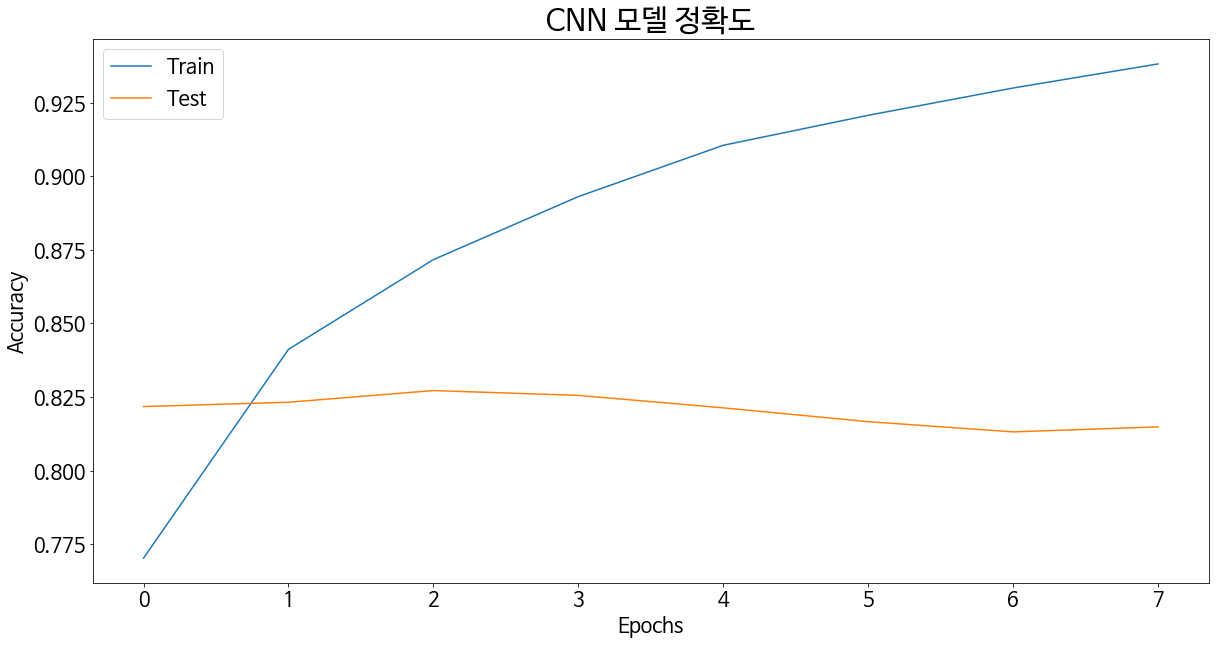

In [136]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Test')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.title('CNN 모델 정확도', fontsize = 30)
plt.show()

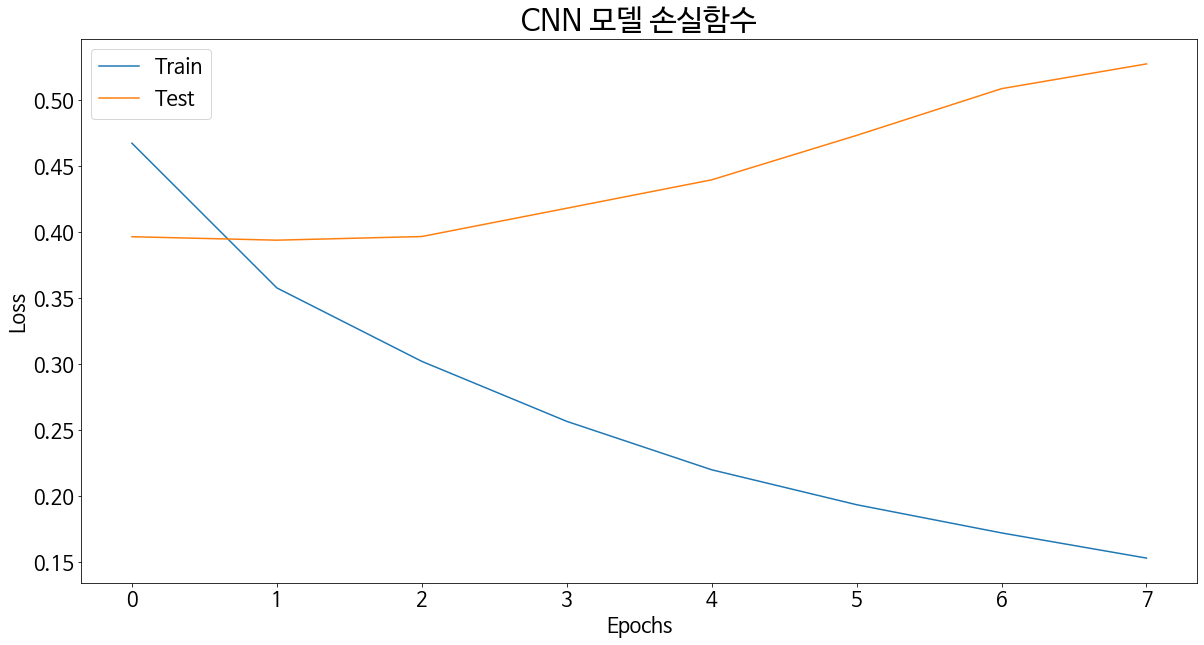

In [137]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Test')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.title('CNN 모델 손실함수', fontsize = 30)
plt.show()

### 5. LSTM 데이터 모델링 진행 및 성능 평가

In [172]:
tf.random.set_seed(411)

model_name = 'lstm_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LEN = 8

kargs = {'model_name' : model_name,
         'vocab_size' : len(word_vocab) + 1,
         'embedding_dimension' : 256,
         'dropout_rate' : 0.5,
         'lstm_dimension' : 256,
         'dense_dimension' : 256,
         'output_dimension' : 1}


class LSTMClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(LSTMClassifier, self).__init__(name = kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units = kargs['dense_dimension'], activation = tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'], activation = tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [173]:
model_lstm = LSTMClassifier(**kargs)
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

history2 = model_lstm.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_split = VALID_SPLIT, callbacks = [earlystop_callback])


Epoch 1/10
235/235 [==============================] - 181s 740ms/step - loss: 0.5792 - accuracy: 0.6876 - val_loss: 0.4558 - val_accuracy: 0.7866
Epoch 2/10
235/235 [==============================] - 169s 721ms/step - loss: 0.4402 - accuracy: 0.7950 - val_loss: 0.4197 - val_accuracy: 0.8054
Epoch 3/10
235/235 [==============================] - 170s 725ms/step - loss: 0.4025 - accuracy: 0.8186 - val_loss: 0.4048 - val_accuracy: 0.8146
Epoch 4/10
235/235 [==============================] - 168s 717ms/step - loss: 0.3807 - accuracy: 0.8312 - val_loss: 0.3993 - val_accuracy: 0.8196
Epoch 5/10
235/235 [==============================] - 167s 711ms/step - loss: 0.3646 - accuracy: 0.8402 - val_loss: 0.3997 - val_accuracy: 0.8185
Epoch 6/10
235/235 [==============================] - 166s 708ms/step - loss: 0.3536 - accuracy: 0.8463 - val_loss: 0.4018 - val_accuracy: 0.8185
Epoch 7/10
235/235 [==============================] - 166s 708ms/step - loss: 0.3436 - accuracy: 0.8519 - val_loss: 0.4037 -

In [174]:
model_lstm.evaluate(X_test, y_test)

1563/1563 [==============================] - 43s 27ms/step - loss: 0.4119 - accuracy: 0.8165


[0.41187581419944763, 0.816540002822876]

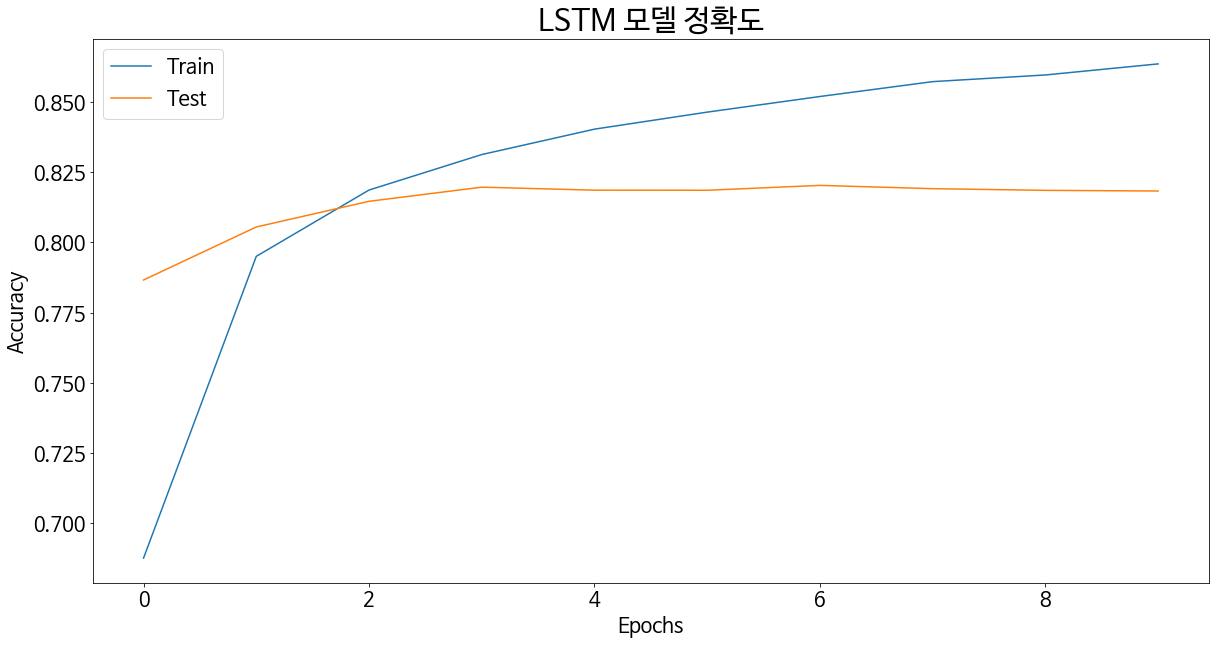

In [175]:
plt.figure(figsize=(20, 10))
plt.plot(history2.history['accuracy'], label = 'Train')
plt.plot(history2.history['val_accuracy'], label = 'Test')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.title('LSTM 모델 정확도', fontsize = 30)
plt.show()

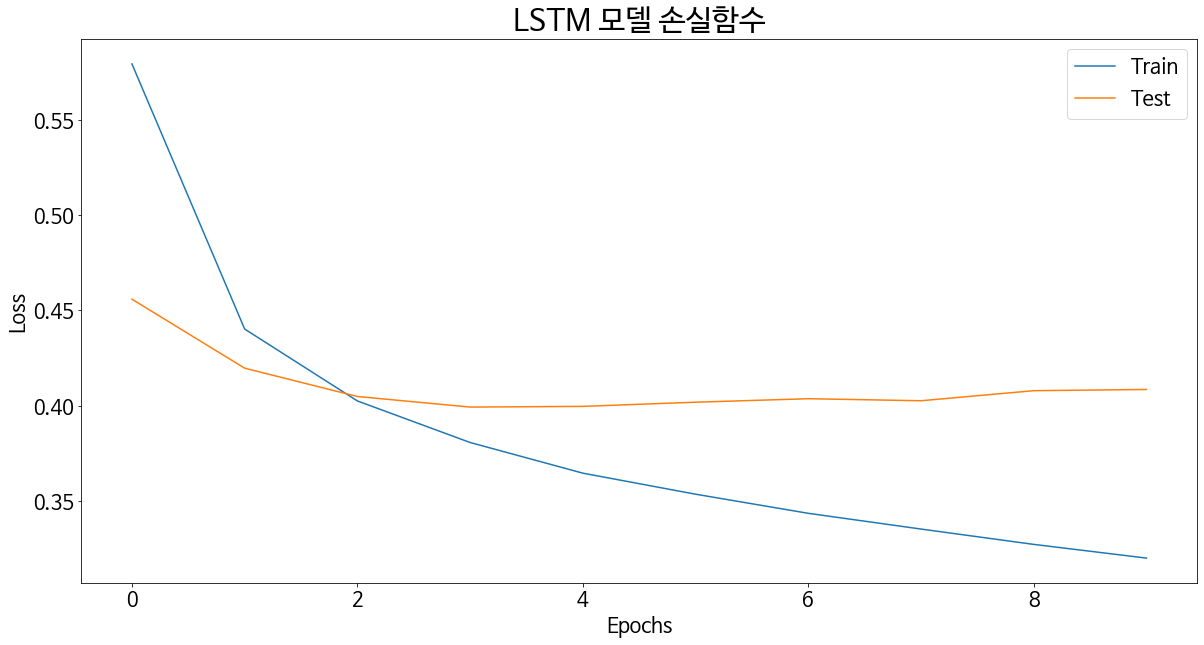

In [176]:
plt.figure(figsize=(20, 10))
plt.plot(history2.history['loss'], label = 'Train')
plt.plot(history2.history['val_loss'], label = 'Test')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.title('LSTM 모델 손실함수', fontsize = 30)
plt.show()

### 6. 결론 및 느낀 점
#### 컴퓨터 비전 분야에서 활용되는 CNN과 전통적인 NLP 분야에서 다뤄지는 RNN 기반 모델 두개를 활용하여 성능을 비교해보았다. 그 차이는 거의 없을 정도로 유사한 형태를 띄고 있다. 기본적인 세팅만 해서 큰 차이가 없었던게 아닐까라는 생각이 들었다.
#### 그게 아니라면 텍스트 임베딩 방법을 달리해보던지 혹은 LSTM 모델보다 발전된 모델인 Attention 기반의 RNN 모델 혹은 나아가 트랜스 포머, 버트의 모델을 활용한다면 성능이 훨씬 개선되지 않을까라는 생각을 한다.
#### 앞으로 새로운 유형의 문제들과 다양한 코드들을 접하여 사람들이 어떤 방식으로 자연어 문제를 풀어나가는지 인사이트를 확보해야 겠다.
#### 뿐만 아니라, EDA와 데이터 전처리 과정에서 어떤 방식으로 했을 때, 성능이 좋아지는지도 한번 고민할 필요성이 있다.